In [9]:
import numpy as np
import pandas as pd
import yfinance as yf
import polars as pl
from datetime import datetime
import matplotlib.pyplot as plt

# -----------------------------
# 1. Download with fallback
# -----------------------------
Y1 = yf.download("EWH", start="2022-01-01")["Close"]
Y2 = yf.download("EWZ", start="2022-01-01")["Close"]
vix = yf.download("^VIX", start="2022-01-01")["Close"]


/var/folders/d3/6ng1rzhj0bq15fcyhb_vxc340000gn/T/ipykernel_2860/222817347.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  Y1 = yf.download("EWH", start="2022-01-01")["Close"]
[*********************100%***********************]  1 of 1 completed
/var/folders/d3/6ng1rzhj0bq15fcyhb_vxc340000gn/T/ipykernel_2860/222817347.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  Y2 = yf.download("EWZ", start="2022-01-01")["Close"]
[*********************100%***********************]  1 of 1 completed
/var/folders/d3/6ng1rzhj0bq15fcyhb_vxc340000gn/T/ipykernel_2860/222817347.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download("^VIX", start="2022-01-01")["Close"]
[*********************100%***********************]  1 of 1 completed


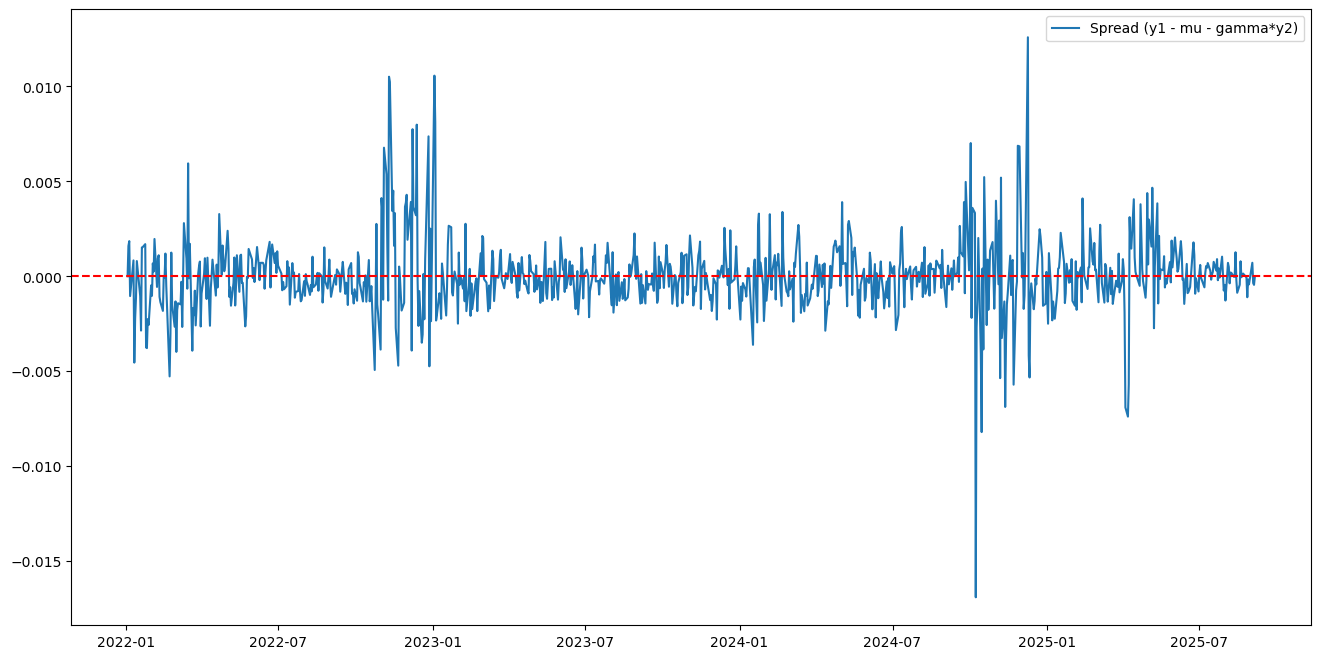

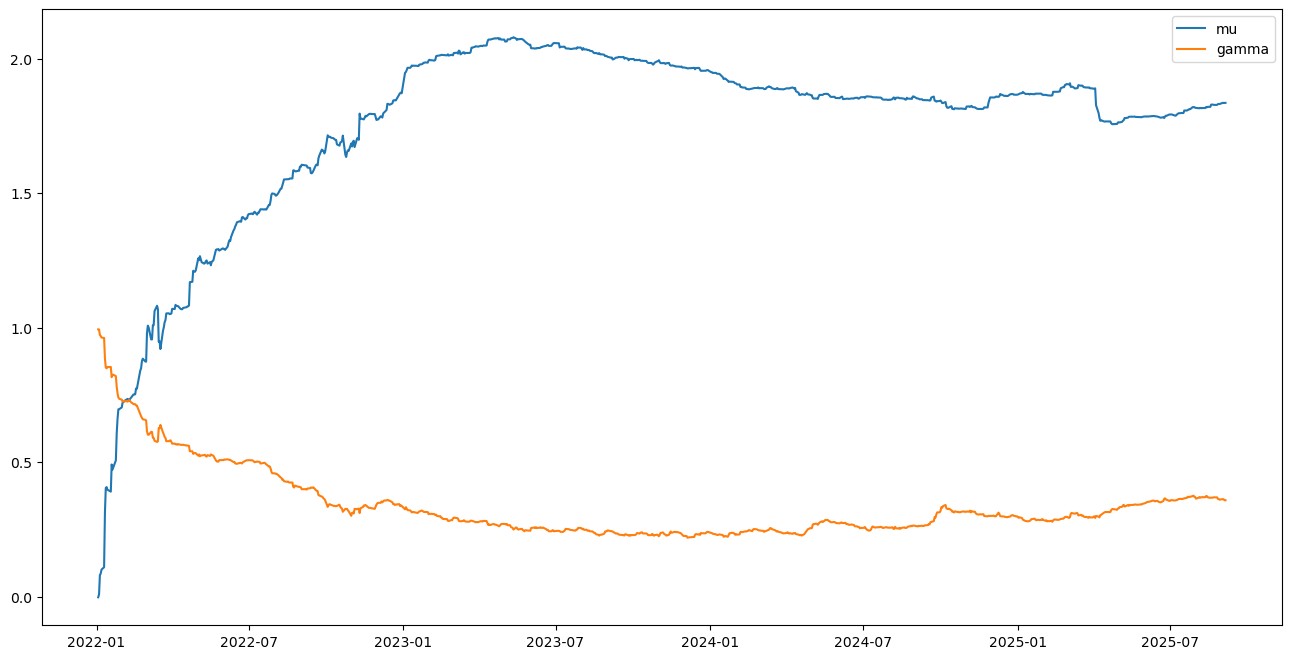

In [10]:
class KalmanFilterMuGamma:
    def __init__(self, x0, P0):
        """
        x0: initial state [mu, gamma]
        P0: initial covariance (2x2)
        """
        self.A = np.eye(2)  # random walk for mu and gamma
        self.x = x0
        self.P = P0

    def predict(self, Q):
        self.x_pred = self.A @ self.x
        self.P_pred = self.A @ self.P @ self.A.T + Q
        return self.x_pred, self.P_pred

    def update(self, z, H, R):
        y = z - H @ self.x_pred
        S = H @ self.P_pred @ H.T + R
        K = self.P_pred @ H.T @ np.linalg.inv(S)

        self.x = self.x_pred + K @ y
        self.P = self.P_pred - K @ H @ self.P_pred
        return self.x, self.P

    def run_filter(self, y1, y2, Q_vals, R_vals, eps=1e-6):
        mu_vals = []
        gamma_vals = []
        spread_vals = []

        for t in range(len(y1)):
            H = np.array([[1.0, y2[t]]])  # dynamic observation matrix

            # Handle Q (can be scalar or array-like)
            Q_val = Q_vals[t] if np.ndim(Q_vals) > 0 else Q_vals
            Q = np.eye(2) * max(Q_val, eps)

            # Handle R
            R_val = R_vals[t] if np.ndim(R_vals) > 0 else R_vals
            R = np.array([[max(R_val, eps)]])

            # Predict + update
            self.predict(Q)
            x_upd, _ = self.update(np.array([[y1[t]]]), H, R)

            mu_vals.append(x_upd[0, 0])
            gamma_vals.append(x_upd[1, 0])
            spread_vals.append(y1[t] - (x_upd[0, 0] + x_upd[1, 0] * y2[t]))

        return np.array(mu_vals), np.array(gamma_vals), np.array(spread_vals)


# -----------------------------
# Example usage
# -----------------------------
y1 = np.log(pd.Series(Y1.values.ravel(), index=Y1.index))
y2 = np.log(pd.Series(Y2.values.ravel(), index=Y2.index))

# Initial state
x0 = np.array([[0.0], [1.0]])
P0 = np.eye(2)

# Noise
Q_vals = np.full(len(y1), 1e-4)       # scalar process noise
R_vals = y1.diff().rolling(50).var().bfill().values  # observation noise

kf = KalmanFilterMuGamma(x0, P0)
mu_vals, gamma_vals, spread_vals = kf.run_filter(y1.values, y2.values, Q_vals, R_vals)

# Plot spread
plt.figure(figsize=(16,8))
plt.plot(y1.index, spread_vals, label='Spread (y1 - mu - gamma*y2)')
plt.axhline(0, color='red', linestyle='--')
plt.legend()
plt.show()

# Plot mu and gamma
plt.figure(figsize=(16,8))
plt.plot(y1.index, mu_vals, label='mu')
plt.plot(y1.index, gamma_vals, label='gamma')
plt.legend()
plt.show()
